Ablauf:
Fiel "AQM_import_API"
1. Import Data via API from Refinitiv to Jupiter Notebook
    - 10 Commodities 10 Years
    - Download monthly data for at least 10 asset prices and at least 10 macroeconomic variables, across countries

2. Create DataFrame, check Data and clean Data if needed:
    - N/A
    - Sprünge?
    - Format?
3. Save clean Data in SQL Lite in DB


Zuerst den Code für 1 Kombination schreiben. Danach ein Loop generieren.

File "AQM_Analyse":
1. Import the clean Data from SQL DB into Notebook
2. Prepare Data for Analysis
3. Create Dataframe to save the Results
4. Create Loop, which executes multivariate OLS regressions using all combinations of 1 and 10 explanatory macroeconomic variables 
5. Save the Results from the Loop into the "Result"-Dataframe
    For each Regression calculate:
        Autocorrelation
        heteroskedasticity
        multicollinearity
6. Export Results to SQL Lite into Table "Results"

In [2]:
import pandas as pd
import numpy as np

import scipy
from scipy import stats
import statsmodels as sm
from statsmodels.regression.linear_model import OLS

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


from datetime import datetime
import time
import datetime

import eikon as ek
creds = 'd505f265d9bd4c0cb7df44481ece31a0ad8d1974'
#API Key Lionel: d505f265d9bd4c0cb7df44481ece31a0ad8d1974
#API Key Raphi:
#API Key Laurin:
ek.set_app_key(creds)


2022-03-22 08:45:32,470 P[10568] [MainThread 28224] Error on checking port 9000 : HTTPConnectionPool(host='localhost', port=9000): Read timed out. (read timeout=20.0)
2022-03-22 08:45:36,563 P[10568] [MainThread 28224] Error on checking port 36036 : HTTPConnectionPool(host='localhost', port=36036): Max retries exceeded with url: /api/v1/data (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000175237985E0>: Failed to establish a new connection: [WinError 10061] Es konnte keine Verbindung hergestellt werden, da der Zielcomputer die Verbindung verweigerte'))
2022-03-22 08:45:36,564 P[10568] [MainThread 28224] Error on handshake port None : Failed to parse: http://localhost:None/api/handshake
2022-03-22 08:45:57,726 P[10568] [MainThread 28224] Error: no proxy address identified.
Check if Eikon Desktop or Eikon API Proxy is running.
2022-03-22 08:45:57,727 P[10568] [MainThread 28224] Port number was not identified, cannot send any request
2022-03-22 08:45:57,7

EikonError: Error code -1 | Port number was not identified. Check if Eikon Desktop or Eikon API Proxy is running.

In [97]:
#Define the Future Contracts
Futures = ['LCOc1',     #ICE Europe Brent Crude 
           'CLc1',      #NYMEX Light Sweet Crude Oil (WTI)
           'NGLNMc1',   #Intercontinetanl Exchange UK NBP Natrual Gas
           'NGc1',      #NYMEX Henry Hub Natural Gas
           'GCc1',      #COMEX Gold
           'SIc1',      #COMEX Silver
           'PLc1',      #NYM Platinum
           'PAc1',      #CYM Palladium
           'Wc1',       #CBoT Wheat
           'Cc1',       #CBoT Corn
           'LCc1',      #CME Live Cattle
           'OJc1'       #ICE Orange Juice
          ]

In [154]:
data_all = pd.DataFrame()
try:
    ek.set_app_key('d505f265d9bd4c0cb7df44481ece31a0ad8d1974')
    itemName=Futures
    dateStart="2012-01-01"
    dateEnd="2022-01-01"

    #Create Loop to inport all Futures:
    for y in range(0,len(Futures)):
        data_input = ek.get_timeseries(Futures[y],fields=["Close"], start_date = dateStart , 
                                    end_date = dateEnd , interval='daily', corax = 'adjusted' )
        data_input['Instrument'] = Futures[y]
        data_all = data_all.append(data_input)
except ek.EikonError as ex:
    print('Eikon Error')
    print(ex)
except Exception as ex:
    print(ex)

data_all

,CLOSE,Instrument
Date,,
2012-01-03,112.13,LCOc1
2012-01-04,113.70,LCOc1
2012-01-05,112.74,LCOc1
2012-01-06,113.06,LCOc1
2012-01-09,112.45,LCOc1
...,...,...
2021-12-27,139.40,OJc1
2021-12-28,140.30,OJc1
2021-12-29,136.70,OJc1


In [13]:
#Unpivot the Data:
data_all = data_all.pivot(columns='Instrument', values='CLOSE')
data_all['Date'] = pd.to_datetime(data_all['Date']).dt.date
#data_all['CREATED_ON'] = datetime.date.today()
data_all

NameError: name 'data_all' is not defined

In [10]:
data_all = pd.read_excel('Data_Refinitiv.xlsx')
data_all = data_all.set_index('Date')
data_all = data_all.drop(['Unnamed: 0', 'CREATED_ON'], axis=1)
data_all 


,CLc1,Cc1,GCc1,LCOc1,LCc1,NGLNMc1,NGc1,OJc1,PAc1,PLc1,SIc1,Wc1
Date,,,,,,,,,,,,
2012-01-03,102.96,658.50,1599.7,112.13,121.550,52.75,2.993,173.50,662.95,1427.3,29.533,657.00
2012-01-04,103.22,658.50,1611.9,113.70,121.625,53.09,3.096,184.75,653.00,1423.1,29.063,650.00
2012-01-05,101.81,643.50,1619.4,112.74,120.950,52.95,2.980,182.25,643.85,1414.5,29.265,629.25
2012-01-06,101.56,643.50,1616.1,113.06,120.325,52.87,3.062,182.00,613.45,1404.5,28.653,624.75
2012-01-09,101.31,652.00,1607.5,112.45,119.950,54.84,3.011,193.95,617.30,1427.5,28.749,641.75
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,75.57,614.75,1808.1,78.60,137.300,NaN,4.060,139.40,1944.30,968.9,22.979,804.00
2021-12-28,75.98,604.75,1810.2,78.94,138.475,NaN,4.055,140.30,1998.40,979.1,23.111,783.50
2021-12-29,76.56,605.50,1805.1,79.23,139.400,233.18,4.024,136.70,1984.80,968.2,22.848,787.75


In [69]:
import time
import datetime
data_all['Date'] = pd.to_datetime(data_all['Date']).dt.date
#data_all['CREATED_ON'] = datetime.date.today()
data_all.to_excel('Data_Refinitiv.xlsx')

KeyError: 'Date'

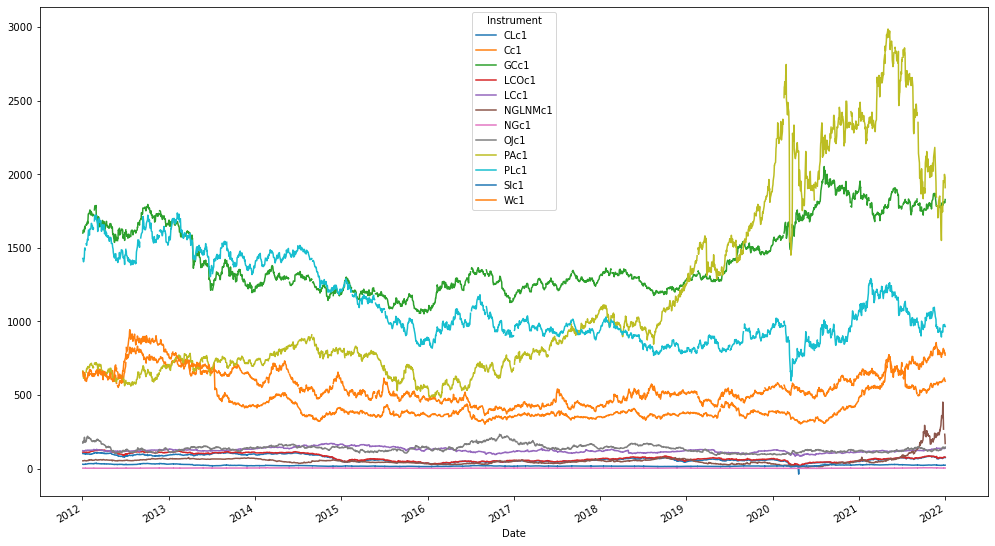

In [164]:
data_all.plot(figsize=(17,10));

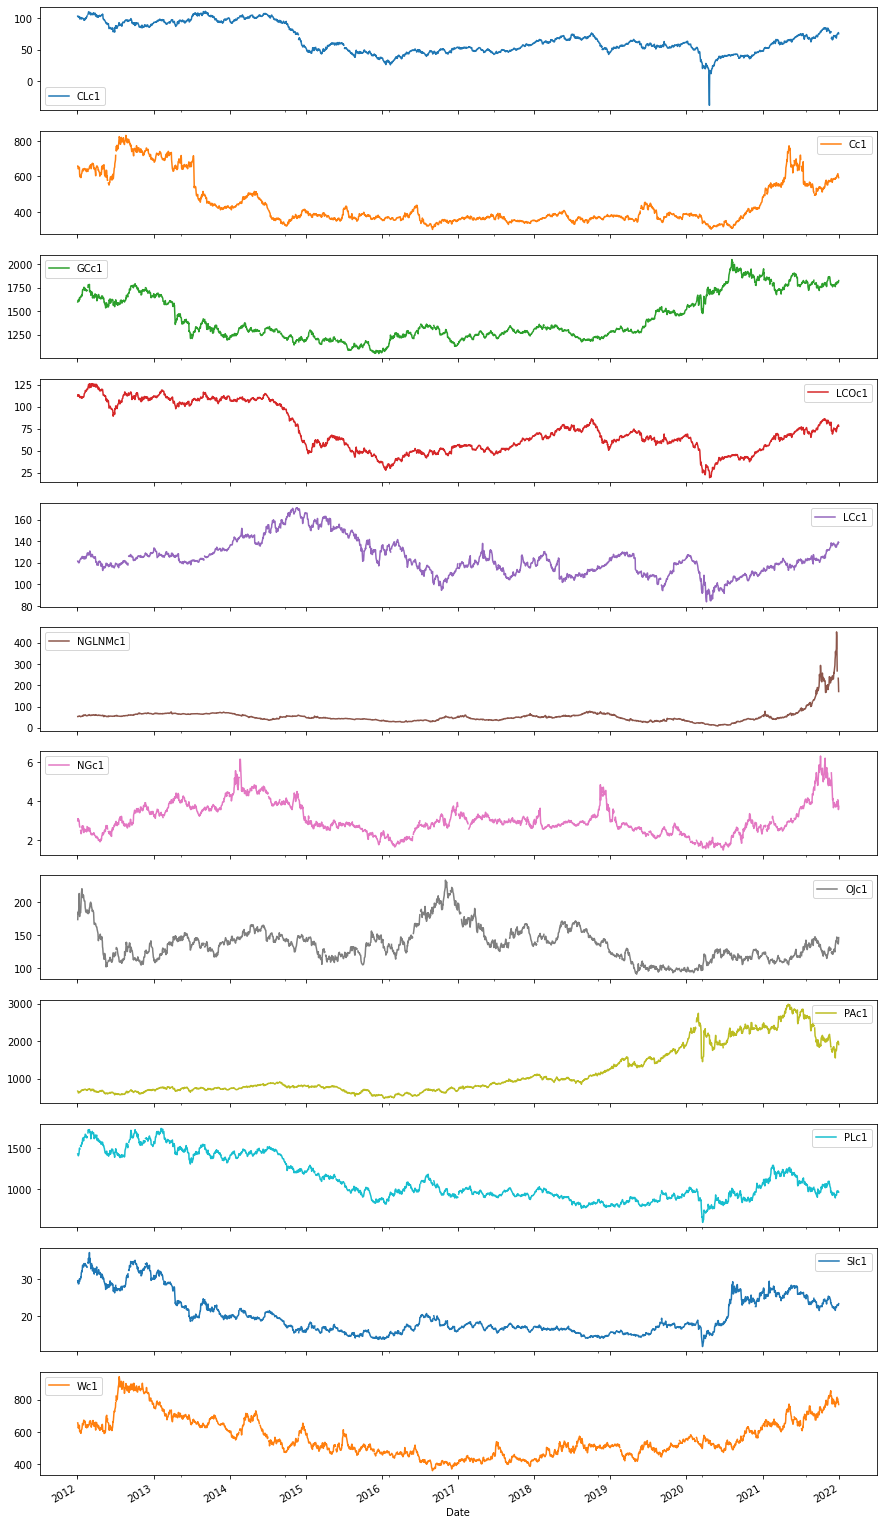

In [168]:
data_all.plot(figsize=(15,30), subplots=True);

In [7]:
#calculate Daily Log Return:
data_all

,CLc1,Cc1,GCc1,LCOc1,LCc1,NGLNMc1,NGc1,OJc1,PAc1,PLc1,SIc1,Wc1,CREATED_ON
Date,,,,,,,,,,,,,
2012-01-03,102.96,658.50,1599.7,112.13,121.550,52.75,2.993,173.50,662.95,1427.3,29.533,657.00,2022-03-22
2012-01-04,103.22,658.50,1611.9,113.70,121.625,53.09,3.096,184.75,653.00,1423.1,29.063,650.00,2022-03-22
2012-01-05,101.81,643.50,1619.4,112.74,120.950,52.95,2.980,182.25,643.85,1414.5,29.265,629.25,2022-03-22
2012-01-06,101.56,643.50,1616.1,113.06,120.325,52.87,3.062,182.00,613.45,1404.5,28.653,624.75,2022-03-22
2012-01-09,101.31,652.00,1607.5,112.45,119.950,54.84,3.011,193.95,617.30,1427.5,28.749,641.75,2022-03-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,75.57,614.75,1808.1,78.60,137.300,NaN,4.060,139.40,1944.30,968.9,22.979,804.00,2022-03-22
2021-12-28,75.98,604.75,1810.2,78.94,138.475,NaN,4.055,140.30,1998.40,979.1,23.111,783.50,2022-03-22
2021-12-29,76.56,605.50,1805.1,79.23,139.400,233.18,4.024,136.70,1984.80,968.2,22.848,787.75,2022-03-22


Save Data in SQL Database (DB)

In [31]:
data_all = pd.read_excel('Data_Refinitiv.xlsx')
data_all = data_all.set_index('Date')
data_all = data_all.drop(['Unnamed: 0', 'CREATED_ON'], axis=1)
data_all 


,CLc1,Cc1,GCc1,LCOc1,LCc1,NGLNMc1,NGc1,OJc1,PAc1,PLc1,SIc1,Wc1
Date,,,,,,,,,,,,
2012-01-03,102.96,658.50,1599.7,112.13,121.550,52.75,2.993,173.50,662.95,1427.3,29.533,657.00
2012-01-04,103.22,658.50,1611.9,113.70,121.625,53.09,3.096,184.75,653.00,1423.1,29.063,650.00
2012-01-05,101.81,643.50,1619.4,112.74,120.950,52.95,2.980,182.25,643.85,1414.5,29.265,629.25
2012-01-06,101.56,643.50,1616.1,113.06,120.325,52.87,3.062,182.00,613.45,1404.5,28.653,624.75
2012-01-09,101.31,652.00,1607.5,112.45,119.950,54.84,3.011,193.95,617.30,1427.5,28.749,641.75
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,75.57,614.75,1808.1,78.60,137.300,NaN,4.060,139.40,1944.30,968.9,22.979,804.00
2021-12-28,75.98,604.75,1810.2,78.94,138.475,NaN,4.055,140.30,1998.40,979.1,23.111,783.50
2021-12-29,76.56,605.50,1805.1,79.23,139.400,233.18,4.024,136.70,1984.80,968.2,22.848,787.75


In [32]:
data_all = data_all.reset_index().rename_axis(None, axis=1)
data_all

,Date,CLc1,Cc1,GCc1,LCOc1,LCc1,NGLNMc1,NGc1,OJc1,PAc1,PLc1,SIc1,Wc1
0,2012-01-03,102.96,658.50,1599.7,112.13,121.550,52.75,2.993,173.50,662.95,1427.3,29.533,657.00
1,2012-01-04,103.22,658.50,1611.9,113.70,121.625,53.09,3.096,184.75,653.00,1423.1,29.063,650.00
2,2012-01-05,101.81,643.50,1619.4,112.74,120.950,52.95,2.980,182.25,643.85,1414.5,29.265,629.25
3,2012-01-06,101.56,643.50,1616.1,113.06,120.325,52.87,3.062,182.00,613.45,1404.5,28.653,624.75
4,2012-01-09,101.31,652.00,1607.5,112.45,119.950,54.84,3.011,193.95,617.30,1427.5,28.749,641.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2578,2021-12-27,75.57,614.75,1808.1,78.60,137.300,NaN,4.060,139.40,1944.30,968.9,22.979,804.00
2579,2021-12-28,75.98,604.75,1810.2,78.94,138.475,NaN,4.055,140.30,1998.40,979.1,23.111,783.50
2580,2021-12-29,76.56,605.50,1805.1,79.23,139.400,233.18,4.024,136.70,1984.80,968.2,22.848,787.75
2581,2021-12-30,76.99,596.00,1812.7,79.32,139.050,210.34,3.561,139.80,1979.20,963.6,23.028,779.75


In [33]:
liste = data_all.values.tolist()
liste

[[Timestamp('2012-01-03 00:00:00'),
  102.96,
  658.5,
  1599.7,
  112.13,
  121.55,
  52.75,
  2.993,
  173.5,
  662.95,
  1427.3,
  29.533,
  657.0],
 [Timestamp('2012-01-04 00:00:00'),
  103.22,
  658.5,
  1611.9,
  113.7,
  121.625,
  53.09,
  3.096,
  184.75,
  653.0,
  1423.1,
  29.063,
  650.0],
 [Timestamp('2012-01-05 00:00:00'),
  101.81,
  643.5,
  1619.4,
  112.74,
  120.95,
  52.95,
  2.98,
  182.25,
  643.85,
  1414.5,
  29.265,
  629.25],
 [Timestamp('2012-01-06 00:00:00'),
  101.56,
  643.5,
  1616.1,
  113.06,
  120.325,
  52.87,
  3.062,
  182.0,
  613.45,
  1404.5,
  28.653,
  624.75],
 [Timestamp('2012-01-09 00:00:00'),
  101.31,
  652.0,
  1607.5,
  112.45,
  119.95,
  54.84,
  3.011,
  193.95,
  617.3,
  1427.5,
  28.749,
  641.75],
 [Timestamp('2012-01-10 00:00:00'),
  102.24,
  652.0,
  1631.0,
  113.28,
  121.2,
  54.47,
  2.941,
  212.75,
  634.65,
  1462.4,
  29.783,
  639.75],
 [Timestamp('2012-01-11 00:00:00'),
  100.87,
  651.5,
  1639.2,
  112.24,
  121.32

In [ ]:
#Create a DB in SQL Lite
#insert the clean Data in the SQL DB: "SQL_DB" into the Table "REFENITIV_DATA":

In [14]:
import sqlite3
from sqlite3 import Error
 
""" create a database connection tool to a SQLite database """
def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()

if __name__ == '__main__':
    create_connection(r"C:\Users\lione\OneDrive\Dokumente\GitHub\AQM\SQL_DB.db")

2.6.0


In [18]:
conn = sqlite3.connect('SQL_DB.db')
c = conn.cursor()
c.execute('''DROP TABLE IF EXISTS REFINITIV_DATA;''')

In [19]:
 
conn = sqlite3.connect('SQL_DB.db')
c = conn.cursor()
c.execute('''CREATE TABLE REFINITIV_DATA (
    "Date" REAL , 
	"LCOc1" TEXT,
    "CLc1" TEXT,
    "NGLNMc1" TEXT,
    "NGc1" TEXT,
    "GCc1" TEXT,
    "SIc1" TEXT,
    "PLc1" TEXT,
    "PAc1" TEXT,
    "Wc1" TEXT,
    "Cc1" TEXT,
    "LCc1" TEXT,
    "OJc1" TEXT
);''')



In [74]:
conn = sqlite3.connect(r"C:\Users\lione\OneDrive\Dokumente\GitHub\AQM\SQL_DB.db")

#Add single Data in Table:
conn.execute("INSERT INTO REFINITIV_DATA(DATE,LCOc1,CLc1,NGLNMc1,NGc1,GCc1 ,SIc1 ,PLc1 ,PAc1 ,Wc1 ,Cc1 ,LCc1 ,OJc1,CREATED_ON ) VALUES ('2022-01-01', '15', '15', '15', '15', '15', '15', '15', '15', '15', '15','15', '15', '2011-01-01')");
conn.commit()


In [34]:
conn = sqlite3.connect(r"C:\Users\lione\OneDrive\Dokumente\GitHub\AQM\SQL_DB.db")
#Add all Data at once:
c = conn.cursor()
c.executemany("INSERT INTO REFINITIV_DATA(DATE, LCOc1,CLc1,NGLNMc1,NGc1,GCc1 ,SIc1 ,PLc1 ,PAc1 ,Wc1 ,Cc1 ,LCc1 ,OJc1) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?)", liste)    
conn.commit()



InterfaceError: Error binding parameter 0 - probably unsupported type.

In [4]:
liste

NameError: name 'liste' is not defined

In [ ]:
#Let's now select the data from the database and pull them to python 
c = conn.cursor()
c.execute("SELECT * FROM REFINITIV_DATA")
#c.execute("SELECT * FROM INSTRUMENT")
#c.execute("SELECT * FROM RESULTS")
new_data=c.fetchall()
new_data